In [1]:
import pandas as pd
import numpy as np
from dataclasses import dataclass, field
from typing import Callable, List, Tuple, Union

import lightgbm as lgb
import catboost as cb
from statsforecast.models import Naive, SeasonalNaive, AutoARIMA

#from tsforge import Recipe, make_mlf_workflow, make_sf_workflow, make_custom_workflow
#import tsforge
from tsforge import Recipe, WorkflowManager, make_mlf_workflow, make_sf_workflow, make_custom_workflow, make_ensemble, plot_cv_results, plot_cv_plan
from tsforge.evaluation import accuracy_table

# Set environment variable to display ID as a separate column in the leaderboard - Nixtla environment Variable
import os
os.environ["NIXTLA_ID_AS_COL"] = "1"

from tsforge.display import enable_notebook_style, style_leaderboard
enable_notebook_style()



c:\Users\tacke\Documents\GitHub\tsforge\.venv\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
c:\Users\tacke\Documents\GitHub\tsforge\.venv\Lib\site-packages\statsforecast\core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
#train_df = pd.read_parquet('../data/input/processed/01_train_df.parquet')

# when working locally
train_df = pd.read_parquet(r"C:\Users\tacke\Downloads\01_train_df.parquet")



In [3]:
# fill sales with 0
train_df1 = train_df.copy()
train_df1['sales'] = train_df1['sales'].fillna(0)

# Fill events with 0
# 
train_df1 = train_df1.drop(['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2','snap_CA','snap_TX','snap_WI'], axis=1)
train_df1.head(2)

,unique_id,date,sales,item_id,dept_id,cat_id,store_id,state_id
0,FOODS_1_001_CA_1,2011-01-29,3.0,FOODS_1_001,FOODS_1,FOODS,CA_1,CA
1,FOODS_1_001_CA_1,2011-01-30,0.0,FOODS_1_001,FOODS_1,FOODS,CA_1,CA


In [4]:
train_df1.columns

Index(['unique_id', 'date', 'sales', 'item_id', 'dept_id', 'cat_id',
       'store_id', 'state_id'],
      dtype='object')

In [ ]:

# Recipe (cast to category for MLForecast/LightGBM)
mlf_recipe=Recipe().step_as_category(["item_id","dept_id","cat_id","store_id","state_id"])

# Workflows
# not catboost explicitly wants cat_columns, so we inject them automatically if missing for simplicity here, but might be good to talk through in training.
# wf1=make_mlf_workflow("Short_Lags",
#                       models=[lgb.LGBMRegressor(),cb.CatBoostRegressor(verbose=0)],
#                       lags=[7,14,28],
#                       date_features=["dayofweek","month"],
#                       static_features=["item_id","dept_id","cat_id","store_id","state_id"],
#                       recipe=mlf_recipe)

wf4=make_mlf_workflow("Expanded_Lags",
                      models=[lgb.LGBMRegressor(verbose=-1, with_intervals=True)],
                      lags=[7,14],
                      date_features=["dayofweek","month"],
                      static_features=["item_id","dept_id","cat_id","store_id","state_id"],
                      recipe=mlf_recipe,
                      )

wf2=make_sf_workflow("Classical",
                     models = [Naive(),SeasonalNaive(season_length=7)],
                     )

wf_ens1 = make_ensemble("Avg Ensemble", [wf2, wf4], method="mean")
wf_ens2 = make_ensemble("Weighted Ensemble",
    members=[(wf2, "SeasonalNaive"), (wf4, "LGBMRegressor")],
    method="weighted", weights=[0.3, 0.7])

# Using custom function
#wf3=make_custom_workflow("Custom_Avg",seasonal_avg)

#workflows=[wf1,wf2,wf3,wf4]
workflows=[wf2,wf4,wf_ens1,wf_ens2]

# Run backtest
manager=WorkflowManager(workflows)
cv_results=manager.cross_validation(train_df1,
                                     h=28, 
                                     n_windows = 2,
                                     level=[80,95])


NameError: name 'n_windows_if_cv' is not defined

c:\Users\tacke\Documents\GitHub\tsforge\.venv\Lib\site-packages\mlforecast\forecast.py:724: UserWarning: Please rerun the `fit` method passing a proper value to prediction intervals to compute them.
  warnings.warn(warn_msg, UserWarning)
c:\Users\tacke\Documents\GitHub\tsforge\.venv\Lib\site-packages\mlforecast\forecast.py:724: UserWarning: Please rerun the `fit` method passing a proper value to prediction intervals to compute them.
  warnings.warn(warn_msg, UserWarning)


In [ ]:
cv_results.head()

,unique_id,date,cutoff,sales,yhat,lo-80,lo-95,hi-80,hi-95,model,workflow,engine
0,FOODS_1_001_CA_1,2016-03-28,2016-03-27,2.0,0.0,-4.408587,-6.742352,4.408587,6.742352,Naive,Classical,statsforecast
1,FOODS_1_001_CA_1,2016-03-29,2016-03-27,1.0,0.0,-2.408587,-4.742352,6.408587,8.742352,Naive,Classical,statsforecast
2,FOODS_1_001_CA_1,2016-03-30,2016-03-27,1.0,0.0,-2.408587,-4.742352,6.408587,8.742352,Naive,Classical,statsforecast
3,FOODS_1_001_CA_1,2016-03-31,2016-03-27,0.0,0.0,-4.408587,-6.742352,4.408587,6.742352,Naive,Classical,statsforecast
4,FOODS_1_001_CA_1,2016-04-01,2016-03-27,4.0,0.0,-3.408587,-5.742352,5.408587,7.742352,Naive,Classical,statsforecast


In [ ]:
cv_results[cv_results.model =='LGBMRegressor'].head()

,unique_id,date,cutoff,sales,yhat,lo-80,lo-95,hi-80,hi-95,model,workflow,engine
834624,FOODS_1_001_CA_1,2016-03-28,2016-03-27,2.0,1.191728,NaN,NaN,NaN,NaN,LGBMRegressor,Expanded_Lags,mlforecast
834625,FOODS_1_001_CA_1,2016-03-29,2016-03-27,1.0,1.026952,NaN,NaN,NaN,NaN,LGBMRegressor,Expanded_Lags,mlforecast
834626,FOODS_1_001_CA_1,2016-03-30,2016-03-27,1.0,1.026952,NaN,NaN,NaN,NaN,LGBMRegressor,Expanded_Lags,mlforecast
834627,FOODS_1_001_CA_1,2016-03-31,2016-03-27,0.0,0.947966,NaN,NaN,NaN,NaN,LGBMRegressor,Expanded_Lags,mlforecast
834628,FOODS_1_001_CA_1,2016-04-01,2016-03-27,4.0,1.031849,NaN,NaN,NaN,NaN,LGBMRegressor,Expanded_Lags,mlforecast


In [ ]:
cv_results.model.unique()

array(['Naive', 'SeasonalNaive', 'LGBMRegressor', 'Avg Ensemble',
       'Weighted Ensemble'], dtype=object)

In [ ]:

scores = accuracy_table(cv_results, 
                        train_df1, 
                        mode='aggregate',
                        include_interval_metrics=True)
scores

,workflow,engine,model,mae_mean,mae_std,rmse_mean,rmse_std,mape_mean,mape_std,smape_mean,...,cwc_80_mean,cwc_80_std,coverage_95_mean,coverage_95_std,width_95_mean,width_95_std,winkler_95_mean,winkler_95_std,cwc_95_mean,cwc_95_std
0,Avg Ensemble,ensemble,Avg Ensemble,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Classical,statsforecast,Naive,1.535098,NaN,3.168474,NaN,94.979396,NaN,87.994988,...,-2.349387,NaN,0.992334,NaN,15.801452,NaN,16.313873,NaN,-13.532791,NaN
2,Classical,statsforecast,SeasonalNaive,1.317319,NaN,2.637390,NaN,83.098020,NaN,84.920711,...,-2.349387,NaN,0.992334,NaN,15.801452,NaN,16.313873,NaN,-13.532791,NaN
3,Expanded_Lags,mlforecast,LGBMRegressor,1.219490,NaN,2.150896,NaN,50.561473,NaN,130.111501,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Weighted Ensemble,ensemble,Weighted Ensemble,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[Info] Multiple series detected (7452). Showing first: FOODS_1_001_CA_1


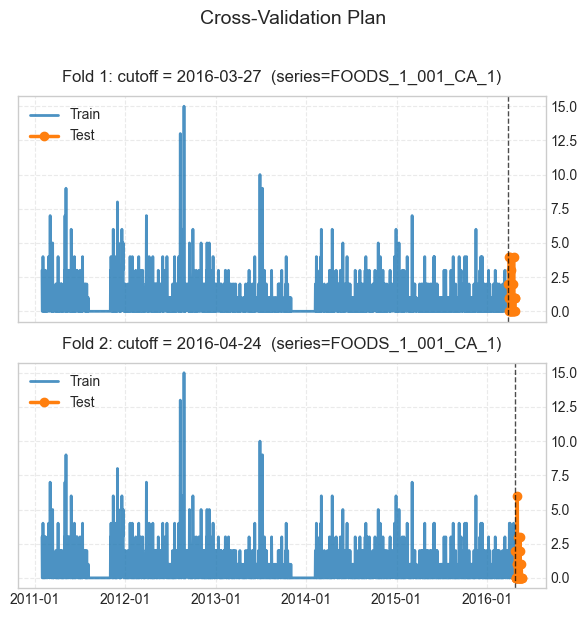

In [ ]:
#from tsforge import plot_cv_plan

plot_cv_plan(manager, train_df1) 

In [ ]:
scores

,workflow,engine,model,mae_mean,mae_std,rmse_mean,rmse_std,mape_mean,mape_std,smape_mean,...,cwc_80_mean,cwc_80_std,coverage_95_mean,coverage_95_std,width_95_mean,width_95_std,winkler_95_mean,winkler_95_std,cwc_95_mean,cwc_95_std
0,Avg Ensemble,ensemble,Avg Ensemble,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Classical,statsforecast,Naive,1.535098,NaN,3.168474,NaN,94.979396,NaN,87.994988,...,-2.349387,NaN,0.992334,NaN,15.801452,NaN,16.313873,NaN,-13.532791,NaN
2,Classical,statsforecast,SeasonalNaive,1.317319,NaN,2.637390,NaN,83.098020,NaN,84.920711,...,-2.349387,NaN,0.992334,NaN,15.801452,NaN,16.313873,NaN,-13.532791,NaN
3,Expanded_Lags,mlforecast,LGBMRegressor,1.219490,NaN,2.150896,NaN,50.561473,NaN,130.111501,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Weighted Ensemble,ensemble,Weighted Ensemble,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
plot_cv_results(scores, metric="mae")

ValueError: Metric 'mae' not found in folds_df

In [ ]:
# leaderboard=manager.cross_validation(train_df1,h=1, n_windows=2 , mode = 'folds')
# leaderboard


In [ ]:
# after CV + evaluation you picked wf_ens1
manager_final = WorkflowManager([wf_ens1])
final_preds = manager_final.forecast(train_df1, h=28)

c:\Users\tacke\Documents\GitHub\tsforge\.venv\Lib\site-packages\statsforecast\core.py:467: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(


In [ ]:
final_preds.head()

,unique_id,date,yhat,workflow,engine,model
0,FOODS_1_001_CA_1,2016-05-23,0.245165,Avg Ensemble,ensemble,Ensemble-mean
1,FOODS_1_001_CA_1,2016-05-24,0.516432,Avg Ensemble,ensemble,Ensemble-mean
2,FOODS_1_001_CA_1,2016-05-25,0.562250,Avg Ensemble,ensemble,Ensemble-mean
3,FOODS_1_001_CA_1,2016-05-26,0.993578,Avg Ensemble,ensemble,Ensemble-mean
4,FOODS_1_001_CA_1,2016-05-27,1.052310,Avg Ensemble,ensemble,Ensemble-mean
